In [33]:
import pandas as pd
import numpy as np

In [34]:
train_df = pd.read_excel('train.xlsx')
train_df = train_df.sort_values(by='dt')
train_df.describe()

,dt,Цена на арматуру
count,400,400.000000
mean,2018-11-01 12:00:00,39229.475000
min,2015-01-05 00:00:00,21000.000000
25%,2016-12-03 06:00:00,31075.000000
50%,2018-11-01 12:00:00,35450.000000
75%,2020-09-29 18:00:00,42000.000000
max,2022-08-29 00:00:00,79000.000000
std,NaN,13407.979668


In [35]:
train_df.head(13)

,dt,Цена на арматуру
0,2015-01-05,32900
1,2015-01-12,32500
2,2015-01-19,32000
3,2015-01-26,30700
4,2015-02-02,30300
5,2015-02-09,30300
6,2015-02-16,30100
7,2015-02-23,29400
8,2015-03-02,29200
9,2015-03-09,29000


In [36]:
train_df.isna().sum()

,0
dt,0
Цена на арматуру,0


In [37]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   dt                400 non-null    datetime64[ns]
 1   Цена на арматуру  400 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.4 KB


In [38]:
train_df.set_index('dt', inplace=True)

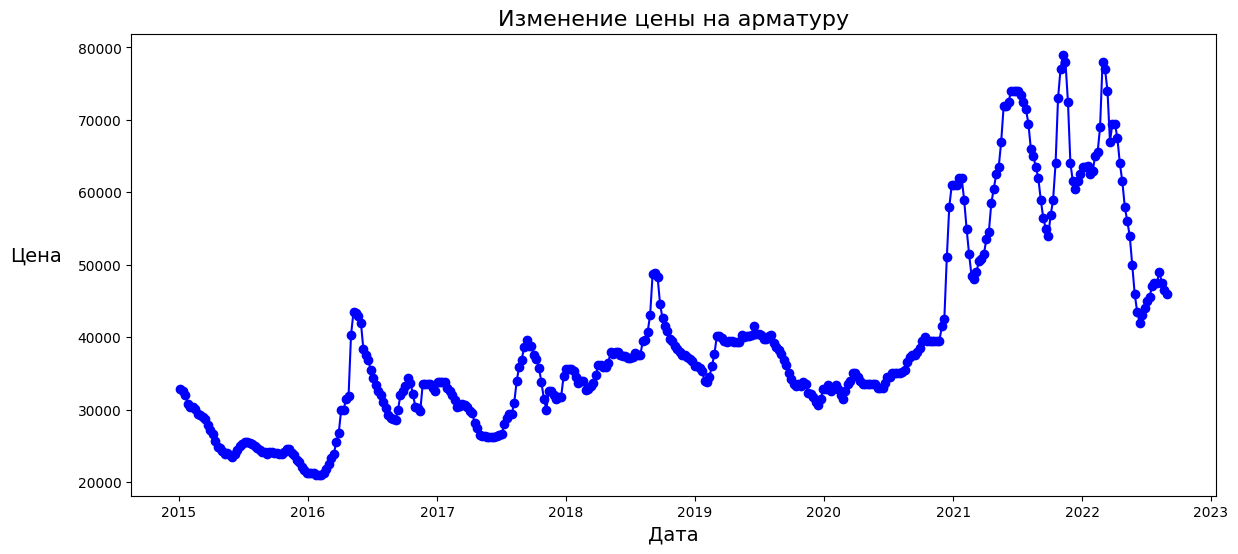

In [39]:
import matplotlib.pyplot as plt

# Рассмотрим изменение цены
plt.figure(figsize=(14, 6))
plt.title('Изменение цены на арматуру', fontsize=16)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Цена', rotation=0, labelpad=30, fontsize=14)
plt.plot(train_df.index, train_df['Цена на арматуру'], marker='o', linestyle='-', color='b')

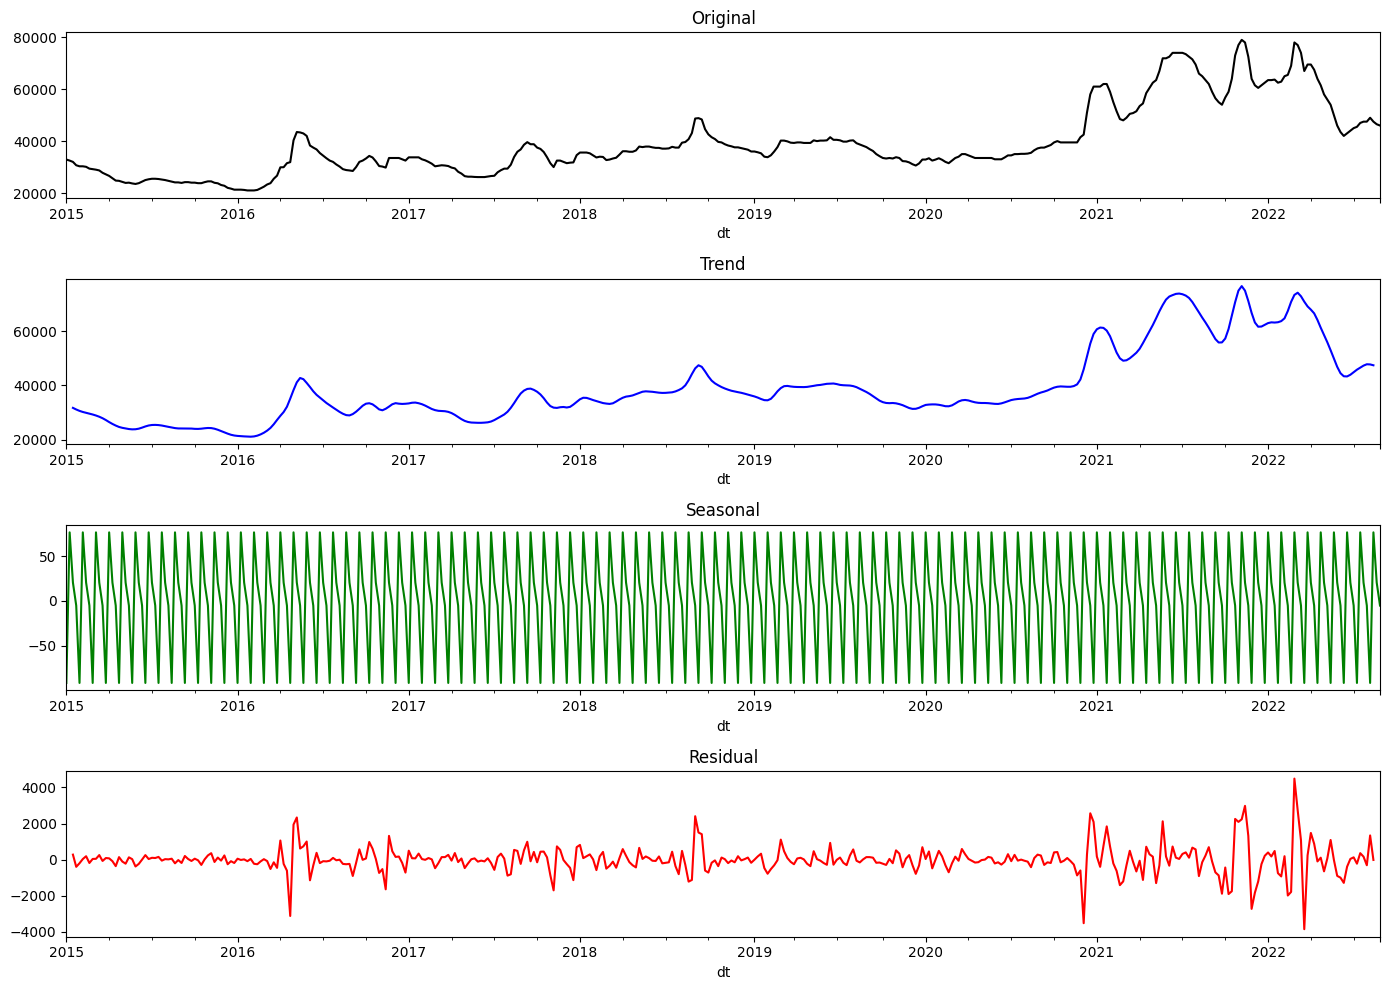

In [40]:
# Разложим ряд на компоненты и ответим: Есть ли у данного ряда тренд? Есть ли у данного ряда сезонность?

from statsmodels.tsa.seasonal import seasonal_decompose

# Выполняем декомпозицию
decomposition = seasonal_decompose(train_df["Цена на арматуру"], model="additive", period=4)

# Визуализация
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(14, 10))
ax[0].set_title("Original")
ax[1].set_title("Trend")
ax[2].set_title("Seasonal")
ax[3].set_title("Residual")

decomposition.observed.plot(ax=ax[0], color="black")
decomposition.trend.plot(ax=ax[1], color="blue")
decomposition.seasonal.plot(ax=ax[2], color="green")
decomposition.resid.plot(ax=ax[3], color="red")

plt.tight_layout()
plt.show()

In [41]:
from statsmodels.tsa.stattools import adfuller
# Проверка стационарности
adf_test = adfuller(train_df["Цена на арматуру"])
print(f"ADF Statistic: {adf_test[0]}, p-value: {adf_test[1]}")

# Ряд является нестационарным

ADF Statistic: -1.9258699893713456, p-value: 0.31999061025699155


In [42]:
train_df['diff_1'] = train_df['Цена на арматуру'].diff()

# Проверка стационарности после первого дифференцирования
adf_test_diff1 = adfuller(train_df['diff_1'].dropna())

print("\nТест Дики-Фуллера после первого дифференцирования:")
print(f"ADF-статистика: {adf_test_diff1[0]}")
print(f"p-значение: {adf_test_diff1[1]}")
print(f"Критические значения: {adf_test_diff1[4]}")

if adf_test_diff1[1] < 0.05:
    print("Ряд стал стационарным после первого дифференцирования.")
else:
    print("Ряд все еще не стационарен, попробуем второе дифференцирование.")


Тест Дики-Фуллера после первого дифференцирования:
ADF-статистика: -7.706061504115209
p-значение: 1.300693837380985e-11
Критические значения: {'1%': np.float64(-3.447405233596701), '5%': np.float64(-2.8690569369014605), '10%': np.float64(-2.5707743450830893)}
Ряд стал стационарным после первого дифференцирования.


In [43]:
train_df = train_df.reset_index()

# Количество лагов (сколько предыдущих недель учитывать)
num_lags = 5

# Добавляем лаговые переменные
for lag in range(1, num_lags + 1):
    train_df[f'lag_{lag}'] = train_df['Цена на арматуру'].shift(lag)

# Добавляем скользящее среднее (по 4 и 8 неделям)
train_df['rolling_mean_4'] = train_df['Цена на арматуру'].rolling(window=4).mean()
train_df['rolling_mean_8'] = train_df['Цена на арматуру'].rolling(window=8).mean()

# Добавляем временные признаки
train_df['year'] = train_df['dt'].dt.year
train_df['month'] = train_df['dt'].dt.month
train_df['week'] = train_df['dt'].dt.isocalendar().week

# test_df['trend'] = np.arange(len(test_df))

# Убираем пропущенные значения (из-за лагов)
train_df = train_df.dropna()

# train_df.set_index('dt', inplace=True)

train_df.head()

,dt,Цена на арматуру,diff_1,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean_4,rolling_mean_8,year,month,week
7,2015-02-23,29400,-700.0,30100.0,30300.0,30300.0,30700.0,32000.0,30025.0,31025.0,2015,2,9
8,2015-03-02,29200,-200.0,29400.0,30100.0,30300.0,30300.0,30700.0,29750.0,30562.5,2015,3,10
9,2015-03-09,29000,-200.0,29200.0,29400.0,30100.0,30300.0,30300.0,29425.0,30125.0,2015,3,11
10,2015-03-16,28700,-300.0,29000.0,29200.0,29400.0,30100.0,30300.0,29075.0,29712.5,2015,3,12
11,2015-03-23,27800,-900.0,28700.0,29000.0,29200.0,29400.0,30100.0,28675.0,29350.0,2015,3,13


автокорреляция

In [44]:
from statsmodels.tsa.stattools import acf

acf(train_df['Цена на арматуру'], nlags=60, fft=False)

array([1.        , 0.99094308, 0.97277135, 0.94984957, 0.92564944,
       0.90136628, 0.87855145, 0.85734848, 0.83851881, 0.82225243,
       0.80844337, 0.79642151, 0.78643927, 0.77854852, 0.77330827,
       0.76978112, 0.76649852, 0.76170647, 0.7550442 , 0.74610116,
       0.7356702 , 0.72420702, 0.71198636, 0.69806897, 0.68279711,
       0.66653718, 0.64922111, 0.63106449, 0.61371188, 0.59695907,
       0.58090876, 0.56639068, 0.55310902, 0.5408053 , 0.52941731,
       0.51878279, 0.50835006, 0.49841117, 0.48850794, 0.47789896,
       0.46604385, 0.45135655, 0.43363024, 0.41355603, 0.39251836,
       0.37015044, 0.34707983, 0.32416228, 0.30182083, 0.28139931,
       0.26334472, 0.24744923, 0.23230846, 0.21869309, 0.20689056,
       0.1967427 , 0.18784398, 0.17986313, 0.17264499, 0.16640246,
       0.16042582])

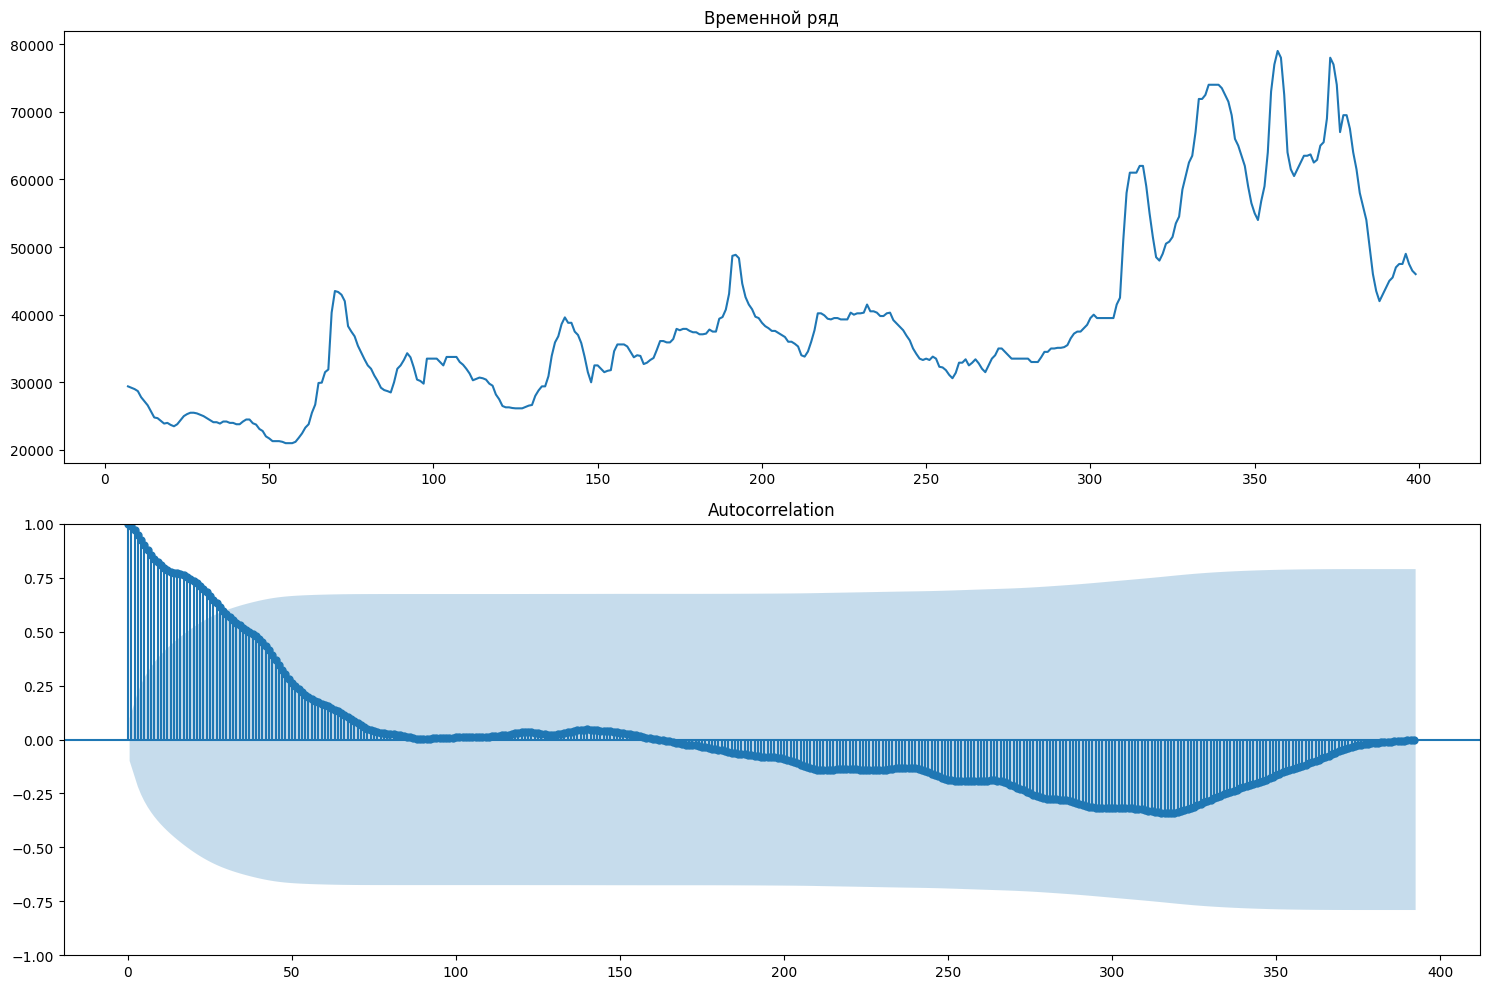

In [45]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

# График временного ряда
train_df['Цена на арматуру'].plot(ax=ax[0], title="Временной ряд")

# График автокорреляции (с корректным числом лагов)
plot_acf(train_df['Цена на арматуру'], lags=len(train_df)-1, ax=ax[1])

plt.tight_layout()
plt.show()

Модели

In [46]:
test_df = pd.read_excel('test.xlsx')

In [47]:
from sklearn.model_selection import train_test_split

X = train_df.drop(columns=['dt', 'Цена на арматуру'])  # dt не нужен
y = train_df['Цена на арматуру']

train_size = int(len(X) * 0.85)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

Модель линейной регрессии

In [48]:
from sklearn.linear_model import LinearRegression

linreg_model = LinearRegression()
linreg_model.fit(X_train, y_train)

linreg_preds = linreg_model.predict(X_test)

In [49]:
from sklearn.metrics import r2_score, mean_absolute_error

rlinreg_mae = mean_absolute_error(y_test, linreg_preds)
linreg_r2 = r2_score(y_test, linreg_preds)

In [50]:
linreg_r2

1.0

In [51]:
rlinreg_mae

1.0728954448033188e-11

Decision Tree

In [52]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X = train_df.drop(columns=['dt', 'Цена на арматуру'])  # dt не нужен
y = train_df['Цена на арматуру']

train_size = int(len(X) * 0.85)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Создание модели DecisionTreeRegressor
dt_model = DecisionTreeRegressor(max_depth=6, random_state=42)
dt_model.fit(X_train, y_train)

y_pred = dt_model.predict(X_test)

# Метрики
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

MAE: 4812.08
RMSE: 5826.91
R²: 0.6790


In [53]:
# Предобработка тестовых данных
test_df = test_df.sort_values('dt')
test_df['diff_1'] = test_df['Цена на арматуру'].diff()

for lag in range(1, num_lags + 1):
    test_df[f'lag_{lag}'] = test_df['Цена на арматуру'].shift(lag)

test_df['rolling_mean_4'] = test_df['Цена на арматуру'].rolling(window=4).mean()
test_df['rolling_mean_8'] = test_df['Цена на арматуру'].rolling(window=8).mean()
test_df['year'] = test_df['dt'].dt.year
test_df['month'] = test_df['dt'].dt.month
test_df['week'] = test_df['dt'].dt.isocalendar().week

test_df = test_df.dropna()

In [54]:
min_len = min(len(test_df), len(y_pred))
test_df = test_df.iloc[:min_len].copy()
# Прогноз
X_test = test_df.drop(columns=['dt', 'Цена на арматуру'])
# y_pred = dt_model.predict(X_test)
test_df['Forecast'] = y_pred[:min_len]

In [55]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

mae_scores = []
r2_scores = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    dt_model.fit(X_train, y_train)
    y_pred = dt_model.predict(X_test)

    mae_scores.append(mean_absolute_error(y_test, y_pred))
    r2_scores.append(r2_score(y_test, y_pred))

print(f"MAE for each fold: {mae_scores}")
print(f"Mean MAE: {np.mean(mae_scores):.2f}")
print(f"Standard deviation of MAE: {np.std(mae_scores):.2f}")
print(f"Standard deviation of R²: {np.std(r2_scores):.4f}")

MAE for each fold: [3874.1758241758243, 2984.769230769231, 1108.728937728938, 3993.319745484401, 4122.307692307692]
Mean MAE: 3216.66
Standard deviation of MAE: 1127.20
Standard deviation of R²: 1.1440


In [56]:
# Финальное обучение и прогноз
dt_model.fit(X, y)
test_df = test_df.drop(columns=['Forecast'])
X_test = test_df.drop(columns=['dt', 'Цена на арматуру'])
y_pred = dt_model.predict(X_test)
test_df['Forecast'] = y_pred

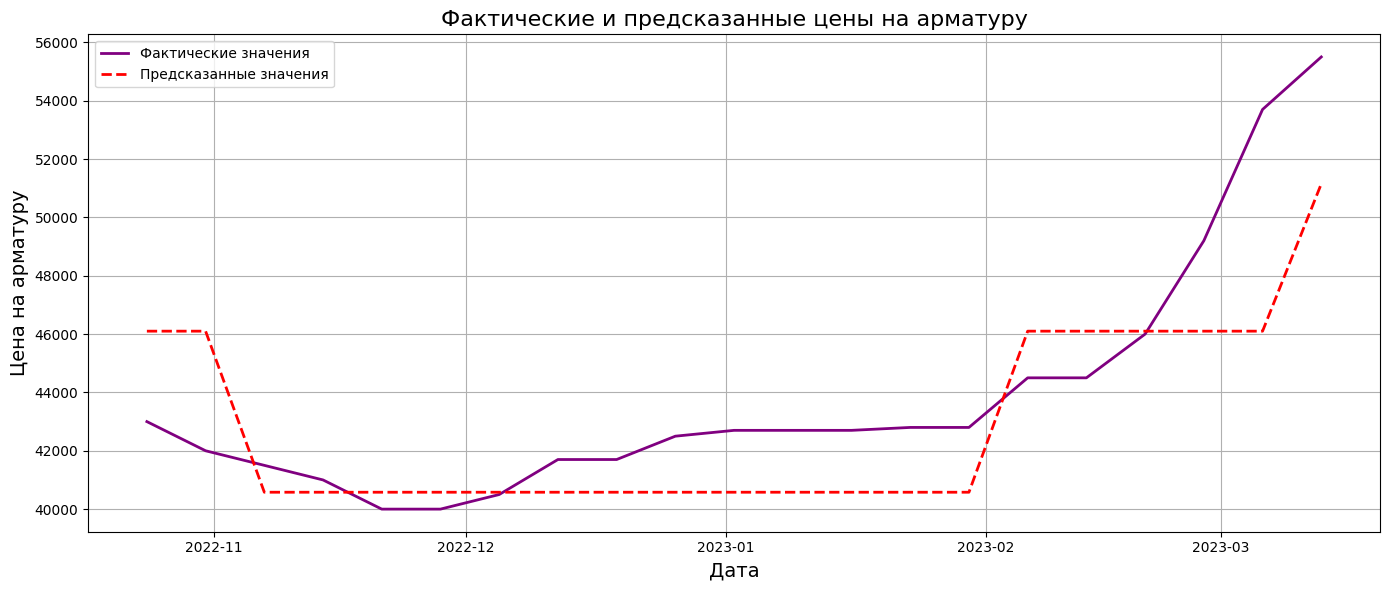

In [57]:
# График
plt.figure(figsize=(14, 6))
plt.plot(test_df['dt'], test_df['Цена на арматуру'], label='Фактические значения', color='purple', linewidth=2)
plt.plot(test_df['dt'], test_df['Forecast'], label='Предсказанные значения', color='red', linestyle='--', linewidth=2)
plt.title('Фактические и предсказанные цены на арматуру', fontsize=16)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Цена на арматуру', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

XGBRegressor

In [58]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer

from sklearn.model_selection import train_test_split

X = train_df.drop(columns=['dt', 'Цена на арматуру'])  # dt не нужен
y = train_df['Цена на арматуру']

train_size = int(len(X) * 0.85)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Создаем модель XGBoost
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    learning_rate=0.03,  # уменьшить скорость обучения
    max_depth=4,  # уменьшить сложность модели
    subsample=0.7,  # уменьшить выборку для каждого дерева
    colsample_bytree=0.7,  # уменьшить количество признаков
    reg_lambda=2,  # L2-регуляризация
    reg_alpha=1,  # L1-регуляризация
    random_state=42
)


xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

MAE: 3009.54
RMSE: 3732.56
R²: 0.8683


In [59]:

# Предобработка тестовых данных (создание признаков)
test_df = test_df.sort_values('dt')
test_df['diff_1'] = test_df['Цена на арматуру'].diff()

# Лаги и скользящее среднее
for lag in range(1, num_lags + 1):
    test_df[f'lag_{lag}'] = test_df['Цена на арматуру'].shift(lag)

test_df['rolling_mean_4'] = test_df['Цена на арматуру'].rolling(window=4).mean()
test_df['rolling_mean_8'] = test_df['Цена на арматуру'].rolling(window=8).mean()
test_df['year'] = test_df['dt'].dt.year
test_df['month'] = test_df['dt'].dt.month
test_df['week'] = test_df['dt'].dt.isocalendar().week

# Убираем пропущенные значения
test_df = test_df.dropna()

In [60]:
min_len = min(len(test_df), len(y_pred))
test_df = test_df.iloc[:min_len].copy()
# Прогноз
X_test = test_df.drop(columns=['dt', 'Цена на арматуру'])
# y_pred = dt_model.predict(X_test)
test_df['Forecast'] = y_pred[:min_len]

In [61]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import TimeSeriesSplit
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    learning_rate=0.03,  # уменьшить скорость обучения
    max_depth=4,  # уменьшить сложность модели
    subsample=0.7,  # уменьшить выборку для каждого дерева
    colsample_bytree=0.7,  # уменьшить количество признаков
    reg_lambda=2,  # L2-регуляризация
    reg_alpha=1,  # L1-регуляризация
    random_state=42
)

tscv = TimeSeriesSplit(n_splits=5)

mae_scores = []
r2_scores = []

for train_index, test_index in tscv.split(X):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    xgb_model.fit(X_train, y_train)


    y_pred = xgb_model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    mae_scores.append(mae)
    r2_scores.append(r2)

print(f"MAE for each fold: {mae_scores}")
print(f"Mean MAE: {np.mean(mae_scores):.2f}")
print(f"Standard deviation of MAE: {np.std(mae_scores):.2f}")

print(f"Standard deviation of R²: {np.std(r2_scores):.4f}")

xgb_model.fit(X, y)

MAE for each fold: [3526.277099609375, 1347.9794921875, 495.94329833984375, 5047.29443359375, 3164.482177734375]
Mean MAE: 2716.40
Standard deviation of MAE: 1618.19
Standard deviation of R²: 0.8483


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

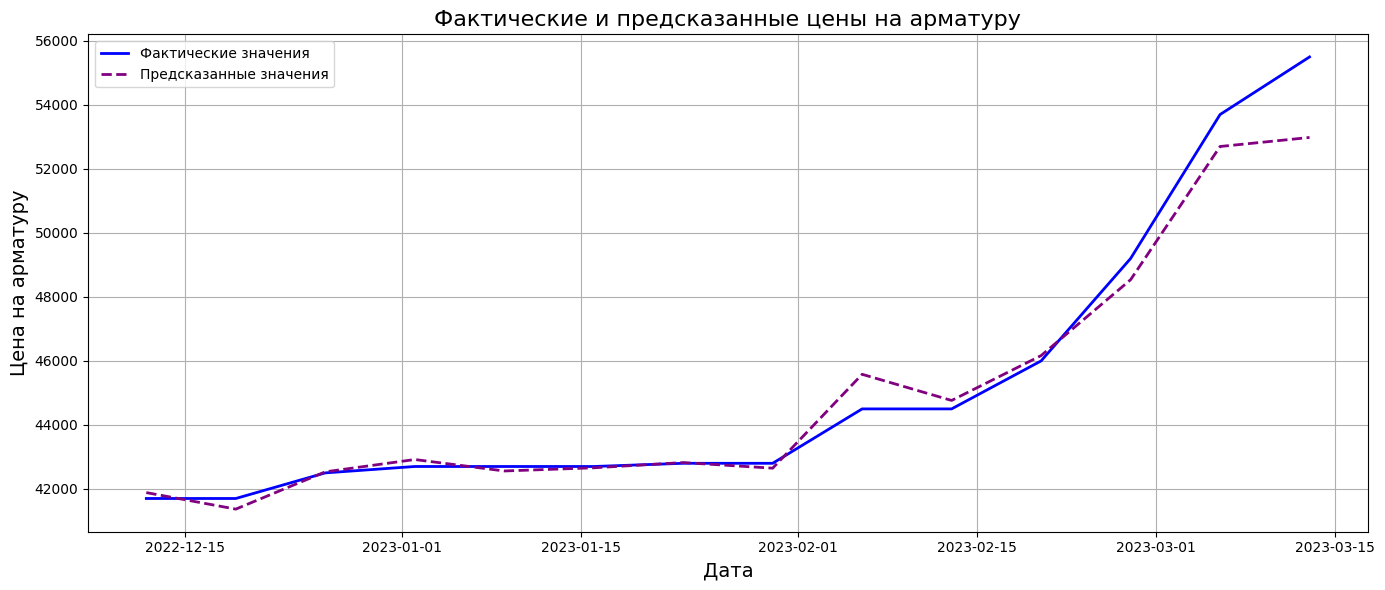

In [62]:
test_df = test_df.drop(columns=['Forecast'])

X_test = test_df.drop(columns=['dt', 'Цена на арматуру'])  # Убираем ненужные колонки
y_pred = xgb_model.predict(X_test)  # Делаем прогноз

test_df['Forecast'] = y_pred

plt.figure(figsize=(14, 6))
plt.plot(test_df['dt'], test_df['Цена на арматуру'], label='Фактические значения', color='blue', linewidth=2)
plt.plot(test_df['dt'], test_df['Forecast'], label='Предсказанные значения', color='purple', linestyle='--', linewidth=2)
plt.title('Фактические и предсказанные цены на арматуру', fontsize=16)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Цена на арматуру', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

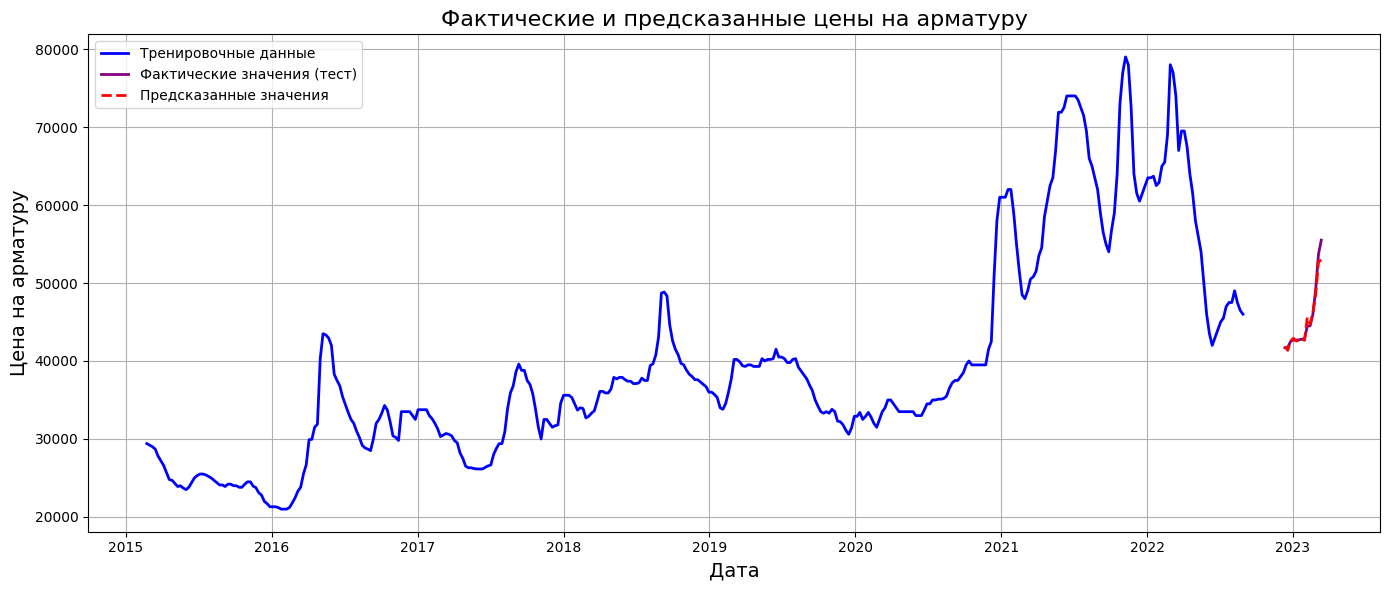

In [63]:
test_df = test_df.drop(columns=['Forecast'])

X_test = test_df.drop(columns=['dt', 'Цена на арматуру'])  # Убираем ненужные колонки
y_pred = xgb_model.predict(X_test)  # Делаем прогноз

test_df['Forecast'] = y_pred

plt.figure(figsize=(14, 6))
plt.plot(train_df['dt'], train_df['Цена на арматуру'], label='Тренировочные данные', color='blue', linewidth=2)
plt.plot(test_df['dt'], test_df['Цена на арматуру'], label='Фактические значения (тест)', color='purple', linewidth=2)
plt.plot(test_df['dt'], test_df['Forecast'], label='Предсказанные значения', color='red', linestyle='--', linewidth=2)
plt.title('Фактические и предсказанные цены на арматуру', fontsize=16)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Цена на арматуру', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Выбор модели

In [64]:
last_train_date = train_df['dt'].iloc[-1]
future_dates = pd.date_range(
    start=last_train_date + pd.Timedelta(weeks=1),
    periods=52,
    freq='W-MON'
)

history = train_df.set_index('dt')['Цена на арматуру'].copy()

forecast_df = pd.DataFrame(index=future_dates, columns=['Forecast'])

for date in forecast_df.index:
    lags = []
    for lag in range(1, num_lags + 1):
        if len(history) >= lag:
            lags.append(history.iloc[-lag])
        else:
            lags.append(np.nan)

    diff_1 = history.diff().iloc[-1] if len(history) >= 2 else np.nan
    rolling_4 = history.rolling(4).mean().iloc[-1] if len(history) >=4 else np.nan
    rolling_8 = history.rolling(8).mean().iloc[-1] if len(history)>=8 else np.nan

    features = pd.DataFrame({
        'diff_1': [diff_1],
        'lag_1': [lags[0]],
        'lag_2': [lags[1]],
        'lag_3': [lags[2]],
        'lag_4': [lags[3]],
        'lag_5': [lags[4]],
        'rolling_mean_4': [rolling_4],
        'rolling_mean_8': [rolling_8],
        'year': [date.year],
        'month': [date.month],
        'week': [date.isocalendar().week]
    })

    features = features.reindex(columns=X_train.columns)

    forecast = xgb_model.predict(features)[0]
    forecast_df.loc[date, 'Forecast'] = forecast
    history.loc[date] = forecast

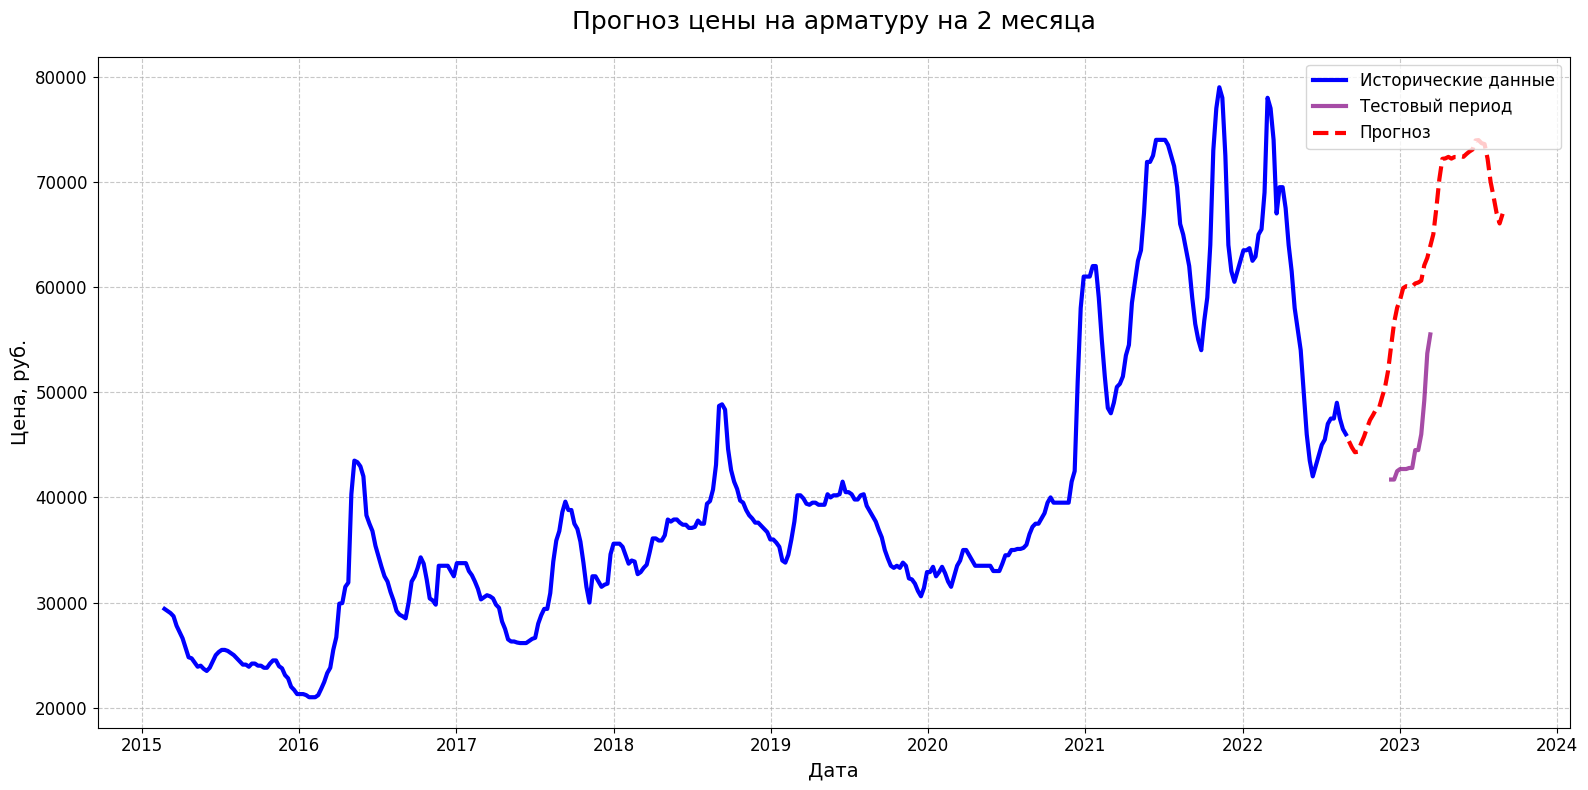

In [65]:
plt.figure(figsize=(16, 8))
plt.plot(train_df['dt'], train_df['Цена на арматуру'],
         label='Исторические данные', color='blue', linewidth=3)

if not test_df.empty:
    test_df = test_df[test_df['dt'] > last_train_date]
    plt.plot(test_df['dt'], test_df['Цена на арматуру'],
             label='Тестовый период', color='purple', linewidth=3, alpha=0.7)

plt.plot(forecast_df.index, forecast_df['Forecast'],
         label='Прогноз', color='red', linestyle='--', linewidth=3)

plt.title('Прогноз цены на арматуру на 2 месяца', fontsize=18, pad=20)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Цена, руб.', fontsize=14)
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()